In [24]:
#LOGREG - tuning hiperparametrów i częsciowa wizualizacja

In [25]:
"""
!pip uninstall -y scikit-learn imbalanced-learn
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0
import os
os._exit(00)
"""

'\n!pip uninstall -y scikit-learn imbalanced-learn\n!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0\nimport os\nos._exit(00)\n'

In [26]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

def random_undersample(X, y, random_state=42):
    rus = RandomUnderSampler(random_state=random_state)
    X_res, y_res = rus.fit_resample(X, y)
    return X_res, y_res

def random_oversample(X, y, random_state=42):
    ros = RandomOverSampler(random_state=random_state)
    X_res, y_res = ros.fit_resample(X, y)
    return X_res, y_res

def apply_smote(X, y, random_state=42, k_neighbors=5):
    smote = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
    X_res, y_res = smote.fit_resample(X, y)
    return X_res, y_res

def apply_adasyn(X, y, random_state=42, n_neighbors=5):
    adasyn = ADASYN(random_state=random_state, n_neighbors=n_neighbors)
    X_res, y_res = adasyn.fit_resample(X, y)
    return X_res, y_res

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import f_oneway, chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
np.random.seed = 42

In [28]:
df = pd.read_csv('learning_set.csv')
df.head()

,Age,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,Lung_Cancer_Diagnosis,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Total_Exposure,Cigarettes_Total,Age_Smoking_Effect,Smoking_Burden,Exposure_Index,Health_Risk_Score,Gender_Female,Gender_Male
0,80,30,29,0,0,0,0,1,0,0,1,317550,2400,317550,32.0,80.0,0,1
1,53,0,0,1,0,0,0,1,0,0,1,0,0,1000,2.0,53.0,0,1
2,47,12,6,1,0,0,1,0,0,0,1,26280,564,54560,7.0,47.0,0,1
3,39,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,44.0,1,0
4,44,0,0,1,0,0,1,1,0,0,2,0,0,2000,3.0,44.0,1,0


In [29]:
# Zakładamy, że kolumna celu nazywa się:
target_column = 'Lung_Cancer_Diagnosis'

X = df.drop(columns=[target_column])
y = df[target_column]



from sklearn.model_selection import train_test_split

X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,        # zachowujemy proporcje klas!
    random_state=42
)



X_train, y_train = apply_adasyn(X_train_temp,y_train_temp)


print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Train class distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test class distribution:\n{y_test.value_counts(normalize=True)}")


Train size: (286420, 17), Test size: (64115, 17)
Train class distribution:
Lung_Cancer_Diagnosis
0    0.501627
1    0.498373
Name: proportion, dtype: float64
Test class distribution:
Lung_Cancer_Diagnosis
0    0.960399
1    0.039601
Name: proportion, dtype: float64


🚀 Start: tuning hiperparametrów...
⏳ Trwa dopasowywanie GridSearchCV...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ GridSearchCV zakończony w 563.66 sekund.
🎯 Najlepsze parametry: {'C': 0.001, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 300, 'penalty': 'elasticnet', 'solver': 'saga'}
🔮 Przewidywanie prawdopodobieństw na zbiorze testowym...
✅ Przewidywanie zakończone w 0.01 sekund.
📈 Obliczanie precision-recall i F1 w zależności od thresholdu...


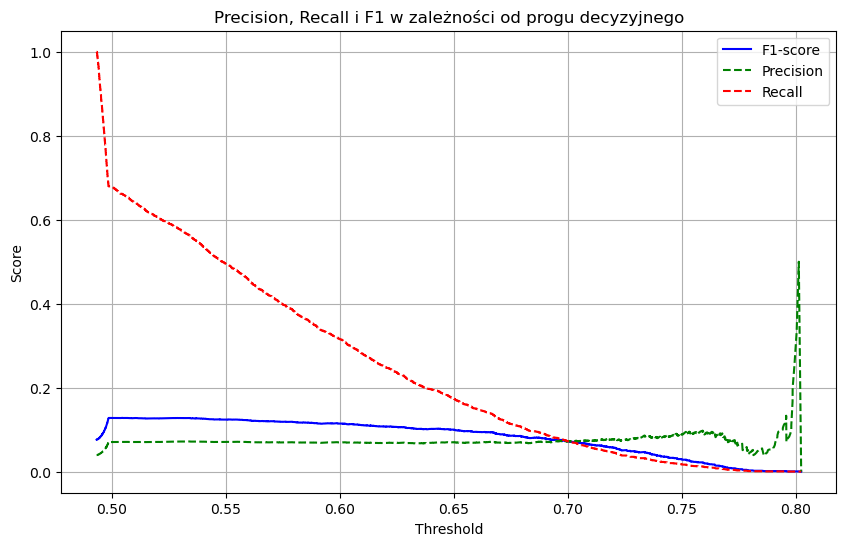

✅ Precision-Recall zakończone w 0.26 sekund.
🧠 Najlepszy threshold (dla max F1): 0.502
📊 Generowanie raportu końcowego...

📊 Classification Report (custom threshold):
              precision    recall  f1-score   support

           0       0.98      0.64      0.77     61576
           1       0.07      0.67      0.13      2539

    accuracy                           0.64     64115
   macro avg       0.53      0.65      0.45     64115
weighted avg       0.94      0.64      0.75     64115


🔍 Confusion Matrix:
[[39276 22300]
 [  837  1702]]
✅ Raport końcowy w 0.07 sekund.
🎉 Cały proces zakończony.


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_recall_curve,
    f1_score,
    average_precision_score
)

# === 1. TUNING HIPERPARAMETRÓW ===
print("🚀 Start: tuning hiperparametrów...")
start_tuning = time.time()

param_grid = [
    
    {
        'penalty': ['elasticnet'],
        'solver': ['saga'],  # tylko saga obsługuje elasticnet
        'C': [0.001, 0.005, 0.01, 0.05, 0.1],
        'l1_ratio': [0.1, 0.2, 0.5],  # nie dawaj 0.0, bo to już 'l2'
        'fit_intercept': [True],
        'max_iter': [300, 500]
    }
]
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
grid = GridSearchCV(logreg, param_grid, cv=3, scoring='average_precision', n_jobs=-1, verbose=1)

print("⏳ Trwa dopasowywanie GridSearchCV...")
grid.fit(X_train, y_train)

end_tuning = time.time()
print(f"✅ GridSearchCV zakończony w {end_tuning - start_tuning:.2f} sekund.")
print("🎯 Najlepsze parametry:", grid.best_params_)

# === 2. PREDYKCJA Prawdopodobieństw ===
print("🔮 Przewidywanie prawdopodobieństw na zbiorze testowym...")
start_pred = time.time()
best_model = grid.best_estimator_
y_probs = best_model.predict_proba(X_test)[:, 1]
print(f"✅ Przewidywanie zakończone w {time.time() - start_pred:.2f} sekund.")

# === 3. KRZYWA PRECISION-RECALL ===
print("📈 Obliczanie precision-recall i F1 w zależności od thresholdu...")
start_curve = time.time()

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1-score", color='blue')
plt.plot(thresholds, precisions[:-1], label="Precision", color='green', linestyle='--')
plt.plot(thresholds, recalls[:-1], label="Recall", color='red', linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall i F1 w zależności od progu decyzyjnego")
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ Precision-Recall zakończone w {time.time() - start_curve:.2f} sekund.")

# === 4. USTALENIE OPTYMALNEGO PROGU ===
best_threshold = thresholds[np.argmax(f1_scores[:-1])]
print(f"🧠 Najlepszy threshold (dla max F1): {best_threshold:.3f}")

# === 5. FINALNA KLASYFIKACJA ===
print("📊 Generowanie raportu końcowego...")
start_final = time.time()

y_pred_custom = (y_probs >= best_threshold).astype(int)
print("\n📊 Classification Report (custom threshold):")
print(classification_report(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred_custom)
print("\n🔍 Confusion Matrix:")
print(cm)

print(f"✅ Raport końcowy w {time.time() - start_final:.2f} sekund.")
print("🎉 Cały proces zakończony.")


In [31]:
"""
Wysoka precyzja dla klasy 0 – prawie brak fałszywych pozytywów dla klasy 0.

Bardzo niska precyzja dla klasy 1 (7%) – sporo fałszywych alarmów, ale…

Wysoka czułość (recall) klasy 1 (67%) – większość faktycznych jedynek została złapana.

F1-score dla klasy 1: 0.13 – bardzo niski, czyli model raczej "zgaduje" klasę 1.

📌 Wniosek: obecnie to klasyfikator działający jak wykrywacz anomalii — jest bardzo ostrożny, ale generuje dużo fałszywych alarmów.
dodatkowo to jest maximum co możemy z tego wycisnąć

"""

'\nWysoka precyzja dla klasy 0 – prawie brak fałszywych pozytywów dla klasy 0.\n\nBardzo niska precyzja dla klasy 1 (7%) – sporo fałszywych alarmów, ale…\n\nWysoka czułość (recall) klasy 1 (67%) – większość faktycznych jedynek została złapana.\n\nF1-score dla klasy 1: 0.13 – bardzo niski, czyli model raczej "zgaduje" klasę 1.\n\n📌 Wniosek: obecnie to klasyfikator działający jak wykrywacz anomalii — jest bardzo ostrożny, ale generuje dużo fałszywych alarmów.\ndodatkowo to jest maximum co możemy z tego wycisnąć\n\n'

In [32]:
feature_names = X_test.columns.tolist()


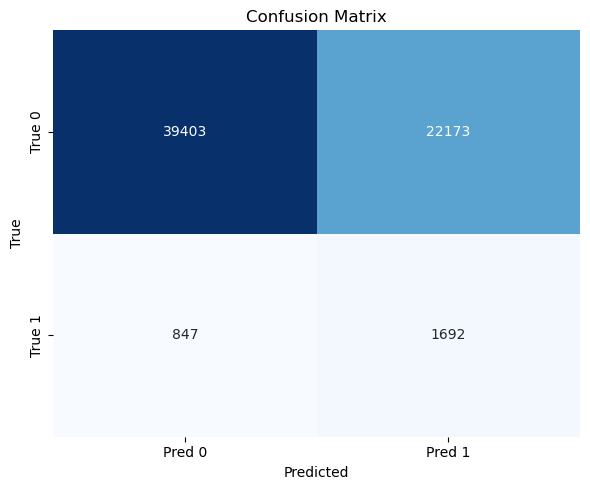

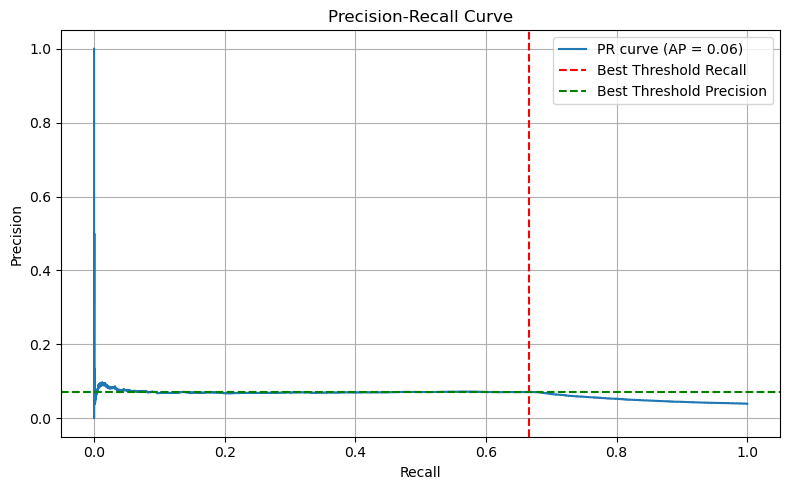

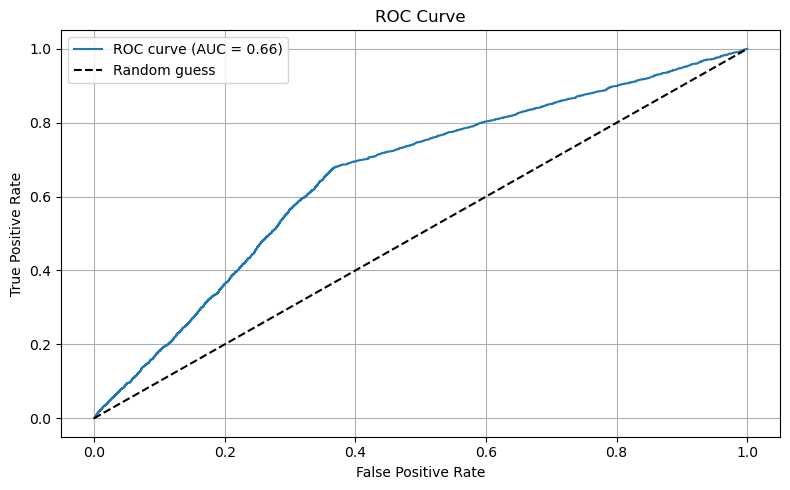

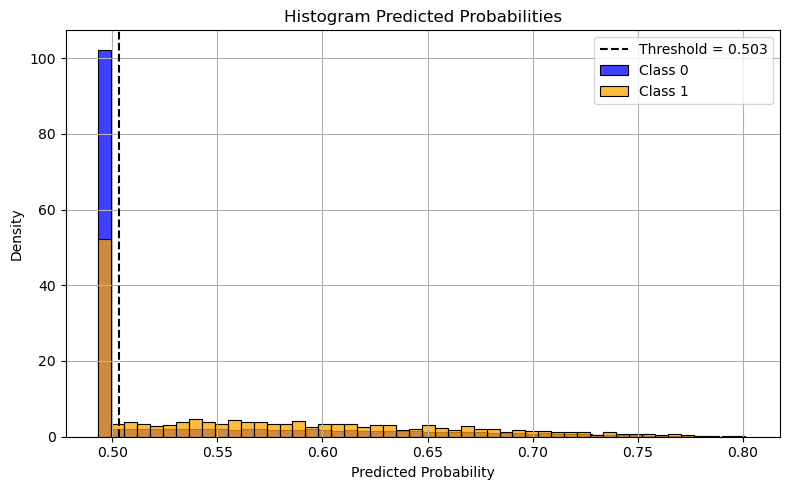

📊 Classification Report:



,precision,recall,f1-score,support
0,0.98,0.64,0.77,61576.00
1,0.07,0.67,0.13,2539.00
accuracy,0.64,0.64,0.64,0.64
macro avg,0.52,0.65,0.45,64115.00
weighted avg,0.94,0.64,0.75,64115.00


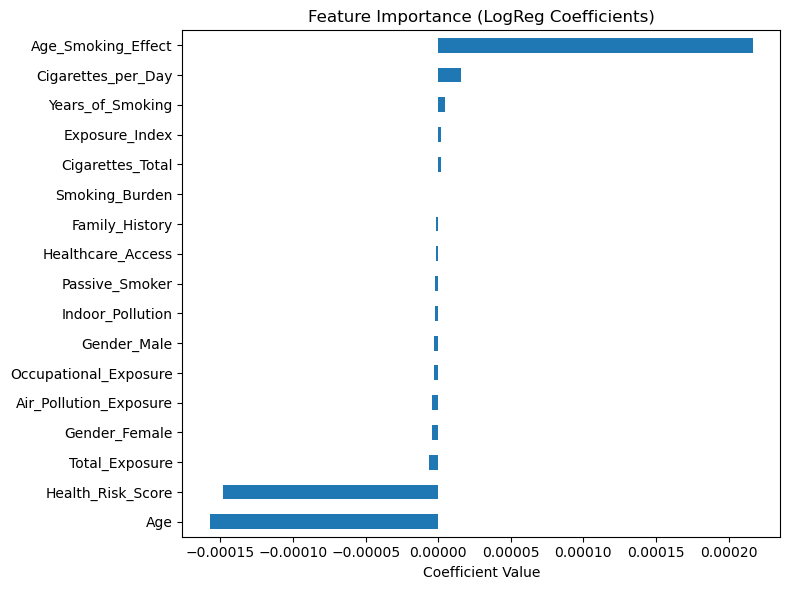

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    average_precision_score,
)
import pandas as pd

# === Zakładamy, że masz: y_test, y_probs (predykcje prawdopodobieństw klasy 1), y_pred (progowane), model ===
# oraz najlepszy threshold:
best_threshold = 0.503  # <- twoja wartość

# ==== 1. Ręczne progowanie ====
y_pred = (y_probs >= best_threshold).astype(int)

# ==== 2. Classification Report ====
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# ==== 3. Confusion Matrix ====
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# ==== 4. Precision-Recall Curve ====
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
ap_score = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.2f})')
plt.axvline(report_dict["1"]["recall"], color='red', linestyle='--', label='Best Threshold Recall')
plt.axhline(report_dict["1"]["precision"], color='green', linestyle='--', label='Best Threshold Precision')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ==== 5. ROC Curve ====
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ==== 6. Histogram of predicted probabilities ====
plt.figure(figsize=(8, 5))
sns.histplot(y_probs[y_test == 0], bins=50, color='blue', label='Class 0', stat='density')
sns.histplot(y_probs[y_test == 1], bins=50, color='orange', label='Class 1', stat='density')
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Threshold = {best_threshold:.3f}')
plt.title("Histogram Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ==== 7. Classification Report as Table ====
print("📊 Classification Report:\n")
display(report_df.round(2))  # Jupyter-friendly
# If running outside Jupyter, replace with:
# print(report_df.round(2).to_string())

# ==== 8. (Optional) Feature Importance ====

if hasattr(best_model, "coef_"):
    feature_importance = pd.Series(best_model.coef_[0], index=feature_names).sort_values()
    plt.figure(figsize=(8, 6))
    feature_importance.plot(kind='barh')
    plt.title("Feature Importance (LogReg Coefficients)")
    plt.xlabel("Coefficient Value")
    plt.tight_layout()
    plt.show()


In [34]:
import pickle
def save_model(model, path):
    with open(path, 'wb') as f:
        pickle.dump(model, f)

save_model(best_model, "models/logreg+adasyn.pkl")